## This notebook is used for testing pytorch dataset and dataloader

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
import warnings
warnings.filterwarnings("ignore")

In [71]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

### Dataset

In [41]:
def __horizontal_flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img

def __vertical_flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def __rotate(img, rotation):
    return img.rotate(90 * rotation)

def get_transform(params, normalize = False):
    transform_list = []
    transform_list.append(transforms.Lambda(lambda img: __horizontal_flip(img, params['horizontal_flip'])))
    transform_list.append(transforms.Lambda(lambda img: __vertical_flip(img, params['vertical_flip'])))
    transform_list.append(transforms.Lambda(lambda img: __rotate(img, params['rotation'])))

    if normalize:
        transform_list += [transforms.ToTensor()]
        transform_list += [transforms.Normalize(params['mean'],
                                                params['std'])]
    return transforms.Compose(transform_list)

class PandaPatchDatasetSeg(Dataset):
    """Panda Tile dataset. With fixed tiles for each slide."""
    def __init__(self, csv_file, image_dir, mask_dir, stats, N = 12):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            N (interger): Number of tiles selected for each slide.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train_csv = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.N = N
        self.mean, self.std = stats

    def __len__(self):
        return len(self.train_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        imgfnames = [os.path.join(self.image_dir, self.train_csv.loc[idx, 'image_id']+'_'+str(i)+'.png')
                  for i in range(self.N)]
        maskfnames = [os.path.join(self.mask_dir, self.train_csv.loc[idx, 'image_id']+'_'+str(i)+'.png')
                  for i in range(self.N)]
        imgs = [self.open_image(fname, convert_mode = 'RGB') for fname in imgfnames]
        masks = [self.open_image(fname) for fname in maskfnames]
        # isup_grade = self.train_csv.loc[idx, 'isup_grade']
        tsfmParams = self.get_params()
        imgtsfm = get_transform(tsfmParams, True)
        masktsfm = get_transform(tsfmParams, False)
        
        imgs = [imgtsfm(img) for img in imgs]
        masks = [masktsfm(mask) for mask in masks]
        ## convert the output to tensor
        imgs = [torch.tensor(img) for img in imgs]
        imgs = torch.stack(imgs)
        masks = [torch.tensor(np.asarray(mask)) for mask in masks]
        masks = torch.stack(masks)
        # isup_grade = torch.tensor(isup_grade)
        sample = {'image': imgs, 'seg_mask': masks}
        return sample

    def open_image(self, fn, convert_mode=None, after_open=None):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)  # EXIF warning from TiffPlugin
            x = Image.open(fn)
            if convert_mode:
                x = x.convert(convert_mode)
        if after_open:
            x = after_open(x)
        return x
    def get_params(self):
        horizontal_flip = np.random.random() > 0.5
        vertical_flip = np.random.random() > 0.5
        rotation = np.random.randint(0, 4)
        return {'horizontal_flip': horizontal_flip, 'vertical_flip': vertical_flip, 'rotation': rotation,
               'mean':self.mean, 'std':self.std}

In [43]:
nfolds = 5
bs = 4
csv_file = './panda-16x128x128-tiles-data/{}_fold_train.csv'.format(nfolds)
image_dir = './panda-16x128x128-tiles-data/train/'
mask_dir = './panda-16x128x128-tiles-data/masks'
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])
# mean = torch.tensor([0.90949707, 0.8188697, 0.87795304])
# std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

In [ ]:
def dataloader_collte_fn(batch):
    imgs = [item['image'] for item in batch]
    imgs = torch.stack(imgs)
    target = [item['seg_mask'] for item in batch]
    target = torch.stack(target)
    return [imgs, target]

In [59]:
dataset = PandaPatchDatasetSeg(csv_file, image_dir, mask_dir, [mean, std])
sample = dataset[20]
print(sample['image'].shape, sample['seg_mask'].shape)

torch.Size([12, 3, 128, 128]) torch.Size([12, 128, 128])


### Dataloader

In [60]:
dataloader = DataLoader(dataset, batch_size=bs,
                        shuffle=True, num_workers=4, collate_fn=dataloader_collte_fn)

In [86]:
img, target = iter(dataloader).next()
print("image size:{}, target sise:{}.".format(img.size(), target.size()))

image size:torch.Size([4, 12, 3, 128, 128]), target sise:torch.Size([4, 12, 128, 128]).


### Plot data batch

In [87]:
grid = utils.make_grid(img[0], nrow = 12, normalize = True) # normalize map image back to [0, 1]

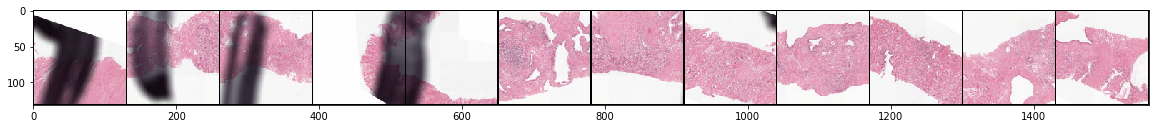

In [88]:
plt.figure(figsize = (20,300))
plt.imshow(grid.numpy().transpose((1, 2, 0)))

### Plot masks

In [89]:
def overlay_mask_on_image(images, masks, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""
    N = len(images)
    f, ax = plt.subplots(N//3,3, figsize=(18,22))

    for i in range(N):
        if i > N // 3 * 3:
            break
        slide_data = (images[i,...].numpy().transpose((1,2,0)) + 1) / 2 * 255
        mask_data = masks[i,...].numpy()
                
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data, 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data, 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)
        
        mask_data = PIL.Image.fromarray(mask_data)
        slide_data = PIL.Image.fromarray(np.uint8(slide_data))
        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)
        
        if N // 3 > 1:
            ax[i//3, i%3].imshow(overlayed_image) 
            ax[i//3, i%3].axis('off')
        else:
            ax[i%3].imshow(overlayed_image) 
            ax[i%3].axis('off')


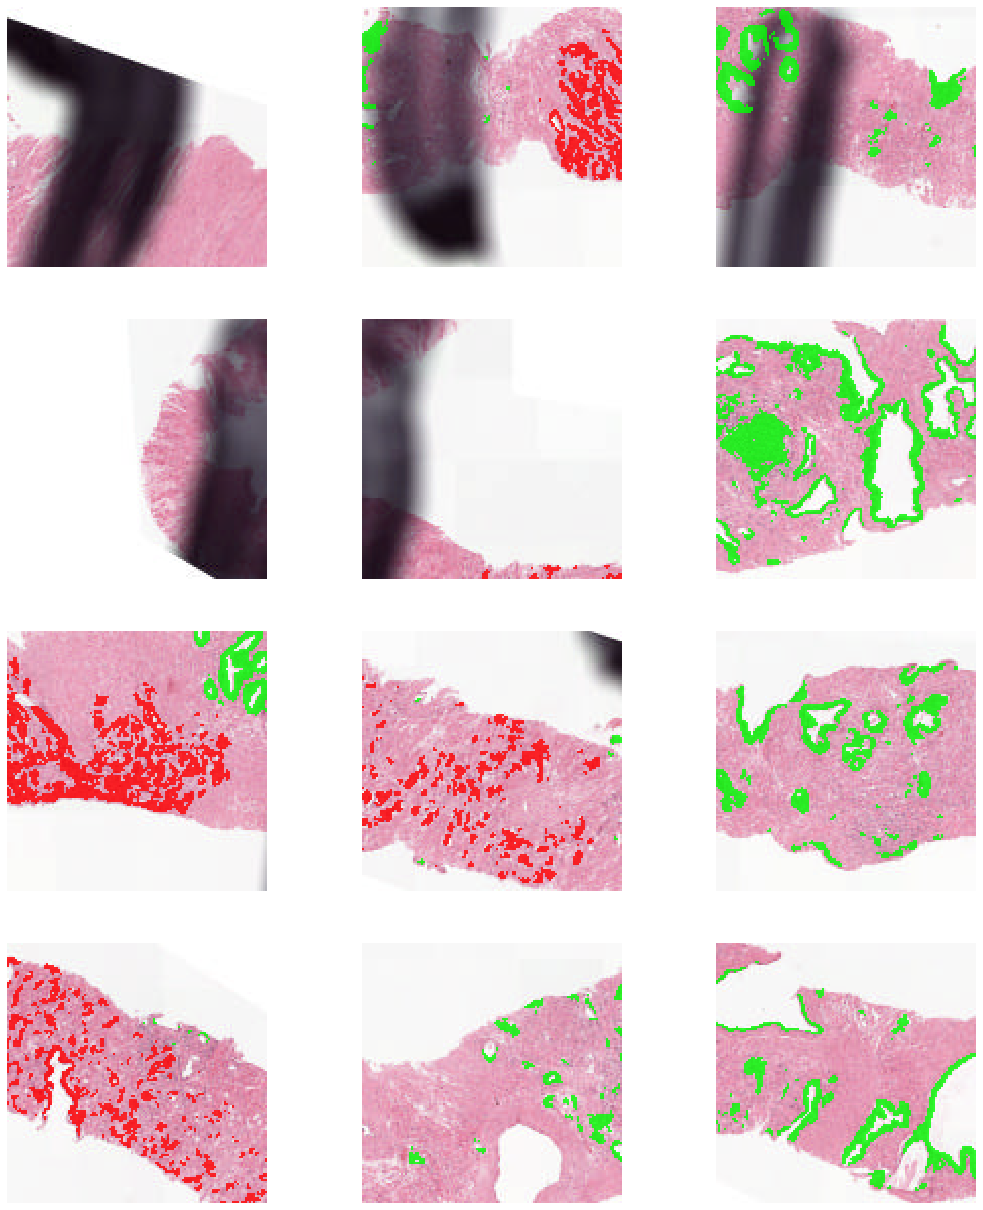

In [90]:
overlay_mask_on_image(img[0], target[0], center='radboud', alpha=0.8, max_size=(800, 800))

### Using cross validation

In [12]:
class crossValInx(object):
    def __init__(self, csv_file):
        self.crossVal_csv = pd.read_csv(csv_file)

    def __call__(self, fold = 0):
        val_idx = self.crossVal_csv.index[self.crossVal_csv['split'] == fold].tolist()
        train_idx = list(set([x for x in range(len(self.crossVal_csv))]) - set(val_idx))
        return train_idx, val_idx

In [27]:
idxSplit = crossValInx(csv_file)
train_idx, val_idx = idxSplit(3)

In [28]:
train = torch.utils.data.Subset(dataset, train_idx)
val = torch.utils.data.Subset(dataset, val_idx)

In [36]:
trainloader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True, num_workers=0, collate_fn=dataloader_collte_fn, pin_memory=True)
valloader = torch.utils.data.DataLoader(val, batch_size=bs, shuffle=True, num_workers=0, collate_fn=dataloader_collte_fn, pin_memory=True)

In [37]:
img, target = iter(trainloader).next()

In [39]:
print("image size:{}, target sise:{}.".format(img.size(), target.size()))

image size:torch.Size([4, 12, 3, 128, 128]), target sise:torch.Size([4]).
